In [2]:
using PyPlot

"""
    circle_overlap(d, r_s, r_p)
Computer the area of overlap of two circles as a function of the distance
between them.

#Arguments
* `d`: the straight-line distance between the centers of the two bodies
* `r_s`: the radius of the star
* `r_p`: the radius of the planet, assumed that r_p < r_s
"""
function circle_overlap(d,r_s,r_p)
  if d <= r_s - r_p
    #the planet is completely within the star
    area = pi*r_p^2
  elseif d >= r_s + r_p
    #there is no overlap
    area = 0
  else
    phi_s = 2*(acos((r_s^2+d^2-r_p^2)/(2*r_s*d)))
    phi_p = 2*(acos((r_p^2+d^2-r_s^2)/(2*r_p*d)))
    area = 0.5*(phi_p*r_p^2-r_p^2*sin(phi_p)+phi_s*r_s^2-r_s^2*sin(phi_s))
  end

  return area
end

circle_overlap (generic function with 1 method)

In [3]:
function read_data_file()
  data = readdlm("mystery_planet2.txt")
  time = data[:,1]
  flux = data[:,2]
  err = data[:,3]
  return (time, flux, err)
end

read_data_file (generic function with 1 method)

In [5]:
time, flux, err = read_data_file();

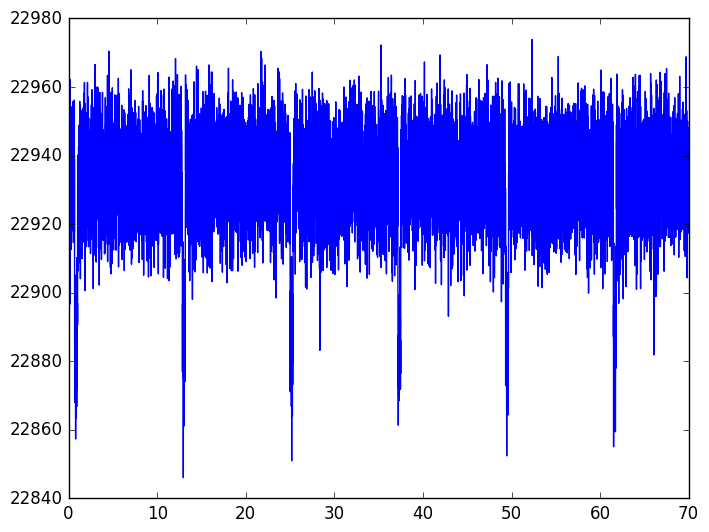

In [7]:
plot(time, flux);

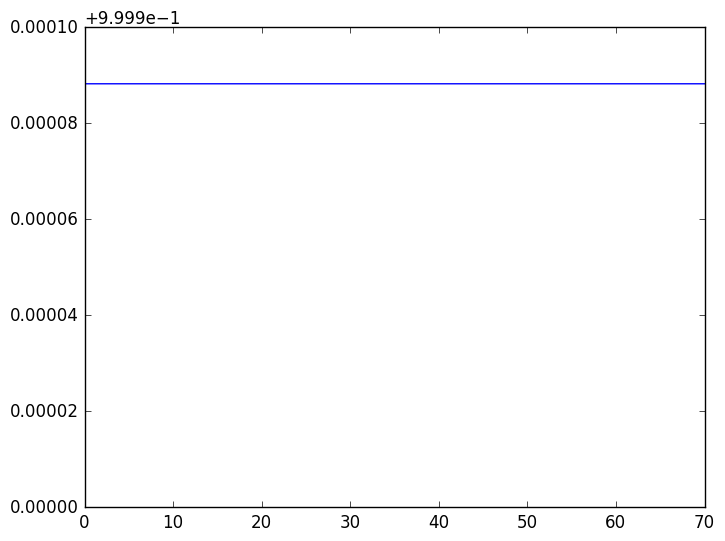

Got t0=-0.12258420090876819, p=12.0, v=0.5156101928174966, k=0.0019328340139111136, b=0.5581354153194809, f0=22932.502352911437


In [25]:
using LsqFit
using PyPlot

"""
    circle_overlap(d, r_s, r_p)
Computer the area of overlap of two circles as a function of the distance
between them.
#Arguments
* `d`: the straight-line distance between the centers of the two bodies
* `r_s`: the radius of the star
* `r_p`: the radius of the planet, assumed that r_p < r_s
"""
function circle_overlap(d,r_s,r_p)
  if d <= r_s - r_p
    #the planet is completely within the star
    area = pi*r_p^2
  elseif d >= r_s + r_p
    #there is no overlap
    area = 0
  else
    phi_s = 2*(acos((r_s^2+d^2-r_p^2)/(2*r_s*d)))
    phi_p = 2*(acos((r_p^2+d^2-r_s^2)/(2*r_p*d)))
    area = 0.5*(phi_p*r_p^2-r_p^2*sin(phi_p)+phi_s*r_s^2-r_s^2*sin(phi_s))
  end

  return area
end


"""
    get_transit_parameters(time, flux, err)
Compute the time of first transit (t0), period (p), sky velocity (v) in units of
stellar radius/day, radius ratio (k), impact parameter (b), and unocculted flux
level (f0) that best match the provided data values.
The eccentricity is assumed zero and the planet is assumed to be fully in
transit (no grazing).
#Arguments
* `time::Array{Float64,1}`: an array containing N time points
* `flux::Array{Float64,1}`: an array containing N flux measurements
* `err::Array{Float64,1}`: an array containing N error measurements
#Return
* `params:Array{Float64,1}`: an array of the best fit parameters
                             [t0, p, v, k, b, f0]
"""
function get_transit_parameters(time, flux, err)
    #params format: [t0, p, v, k, b, f0]
    params = [0.0, length(time)/5.5, 0.5, 0.005, 0.01, mean(flux)] #initial guesses

      #closure function called by curve_fit
      function model_transit(time, params)
        t0, p, v, k, b, f0 = params
        p = Int(floor(p)) #make sure p is an integer for our loops
        #calculate the expected flux for each time point using the given
        #parameters.
        flux = zeros(Float64,length(time))

        for i=1:p #the signal should repeat every period (p) samples
            t = time[i]

            dist = abs((1-b^2)^0.5-(t-t0)*v) #the distance between the planet and star centers
            r_p = k #radius of planet in terms of stellar radii, k=r_p/r_s
            r_s = 1.0 #radius of star in units of stellar radii
            overlap = circle_overlap(dist, r_s, r_p) #percent of star covered

            j = 0
            while i+j*p <= length(time) #loop over all points in the period
            flux[i+j*p] = f0*(1-overlap) #calculate the total flux
            j+=1
          end
        end
        return flux
      end

    fit = curve_fit(model_transit, time, flux, 1./err.^2, params)
    t0, p, v, k, b, f0 = fit.param
    #p is in units of samples, convert to days
    p = p*(time[2]-time[1])
    plot(time, model_transit(time, [t0, p, v, k, b, f0])/22932.502352911437)
    ylim(0.9999,1.000)
    show()
    return [t0, p, v, k, b, f0]
    
end


function read_data_file(filepath)
    data = readdlm(filepath)
    time = (data[:,1])
    flux = (data[:,2])
    err = (data[:,3])
    return (time, flux, err)
end

time, flux, err = read_data_file("mystery_planet2.txt")
t0, p, v, k, b, f0 =  get_transit_parameters(time, flux, err)
println("Got t0=$(t0), p=$(p), v=$(v), k=$(k), b=$(b), f0=$(f0)")

# plot(time,flux)

# get_transit_parameters(time, flux, err)
